#Transfer Learning using Inception-v3 for Image Classification

In my [previous post](https://https://medium.com/analytics-vidhya/end-to-end-image-classification-project-using-tensorflow-46e78298fa2f), I worked on a subset of the original Dogs vs. Cats [Dataset](https://https://www.kaggle.com/c/dogs-vs-cats/data) (3000 images sampled from the original dataset of 25000 images) to build an image classifier capable of classifying images of Dogs and Cats with 82% accuracy.

This project is in continuation with the previous one where we try to improve our performance even further.

When we have a relatively small dataset, a super effective technique is to use **Transfer Learning** where we use a pre-trained model. This model has been trained on an extremely large dataset, and we would be able to transfer weights which were learned through hundreds of hours of training on multiple high powered GPUs.

Many such models are open sourced such as VGG-19 and Inception-v3. They were trained on millions of images with extremely high computing power which can be very expensive to achieve from scratch.

We are using the **Inception-v3** model in the project.

Transfer Learning has become immensely popular because it considerably reduces training time, and requires a lot less data to train on to increase performance.

**Get the Data** (subset)

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2022-12-10 06:19:28--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   114MB/s    in 0.6s    

2022-12-10 06:19:29 (114 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



**Import Libraries**

In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

The os library gives us access to the file system, and the zipfile library allows us to unzip the data.

**Create the respective directories**

In [ ]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

The contents of the .zip are extracted to the base directory /tmp/cats_and_dogs_filtered.zip

**Examples**

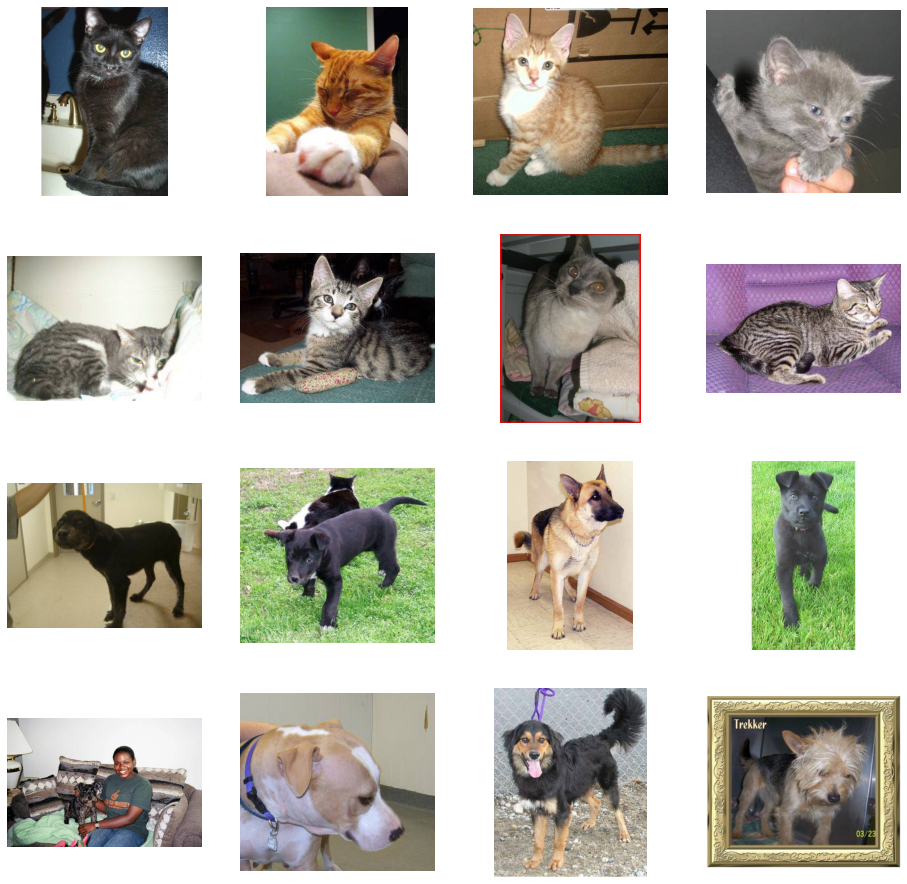

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )


next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

**Import the Inception model**

We are going to use all the layers in the model except for the last fully connected layer as it is specific to the [ImageNet](https://http://image-net.org/challenges/LSVRC/) competition.

In [ ]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

Make all the layers non trainable (We can retrain some of the lower layers to increase performance. Keep in mind that this may lead to overfitting)

In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

**Define a Callback class that stops training once accuracy reaches 95%**

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.959):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

We use binary_crossentropy as the loss metric as we have 2 target classes (it's a binary classification problem)

Our optimizer is **RMSprop** with a learning rate of **0.0001** (We can experiment with this; Adam and Adagrad optimizers would also work well)

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

**Rescale the Images**

The data generators read pictures in our source folders, convert them to float32 tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images.

Input data to the neural networks should be normalized to aid in processing. We will preprocess our images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).

In Keras this can be done via the **keras.preprocessing.image.ImageDataGenerator** class using the **rescale** parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs: fit_generator, evaluate_generator, and predict_generator.




We also perform **Image Augmentation** where we change the images a bit by rotating them, squashing them, etc.

We can implement this using the ImageDataGenerator Class



```
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
```


**Some options that are available:**


*   rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
*   width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
*   shear_range is for randomly applying shearing transformations
*   zoom_range is for randomly zooming inside pictures
*   horizontal_flip is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures)
*   fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift

**Flow images in batches of 20 using train _datagen and test_datagen**

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/100


<ipython-input-28-184f209c0d04>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 - 22s - loss: 1.0184 - acc: 0.8505 - val_loss: 0.2296 - val_acc: 0.9460 - 22s/epoch - 225ms/step
Epoch 2/100
100/100 - 18s - loss: 0.4236 - acc: 0.8835 - val_loss: 0.1135 - val_acc: 0.9610 - 18s/epoch - 176ms/step
Epoch 3/100
100/100 - 18s - loss: 0.4084 - acc: 0.8950 - val_loss: 0.1849 - val_acc: 0.9470 - 18s/epoch - 176ms/step
Epoch 4/100
100/100 - 19s - loss: 0.3228 - acc: 0.8985 - val_loss: 0.1259 - val_acc: 0.9610 - 19s/epoch - 193ms/step
Epoch 5/100
100/100 - 18s - loss: 0.3560 - acc: 0.9100 - val_loss: 0.4556 - val_acc: 0.9140 - 18s/epoch - 176ms/step
Epoch 6/100
100/100 - 17s - loss: 0.2968 - acc: 0.9175 - val_loss: 0.2245 - val_acc: 0.9410 - 17s/epoch - 175ms/step
Epoch 7/100
100/100 - 18s - loss: 0.2870 - acc: 0.9205 - val_loss: 0.1399 - val_acc: 0.9550 - 18s/epoch - 178ms/step
Epoch 8/100
100/100 - 19s - loss: 0.3459 - acc: 0.9130 - val_loss: 0.1275 - val_acc: 0.9620 - 19s/epoch - 194ms/step
Epoch 9/100
100/100 - 18s - loss: 0.3112 - acc: 0.9160 - val_loss: 0.1509 - 

We were able to achieve a validation accuracy of **95%**
This is the kind of result we were hoping for using **Transfer Learning**; Building upon a pre-trained model and using it in our custom application which was able to achieve great performance after training on just 2000 images.

**Plot Accuracy and Loss**

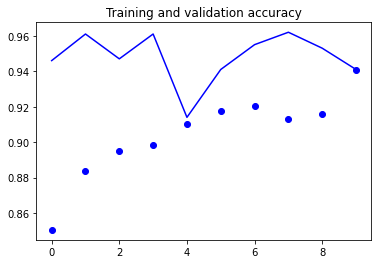

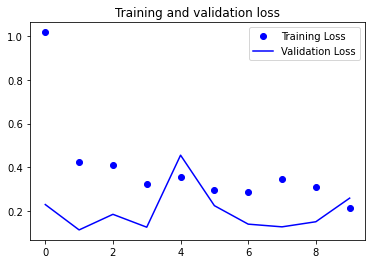

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**An approach where we do not use all the layers in the pre-trained model**

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7') #Only use layers including and above 'mixed7'
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

last layer output shape:  (None, 7, 7, 768)
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100


<ipython-input-34-3511f73afe7b>:45: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 - 22s - loss: 0.3234 - acc: 0.8740 - val_loss: 0.1066 - val_acc: 0.9610 - 22s/epoch - 216ms/step
Epoch 2/100
100/100 - 19s - loss: 0.2317 - acc: 0.9150 - val_loss: 0.2257 - val_acc: 0.9300 - 19s/epoch - 194ms/step
Epoch 3/100
100/100 - 18s - loss: 0.1967 - acc: 0.9280 - val_loss: 0.1950 - val_acc: 0.9400 - 18s/epoch - 178ms/step
Epoch 4/100
100/100 - 18s - loss: 0.2050 - acc: 0.9270 - val_loss: 0.1594 - val_acc: 0.9470 - 18s/epoch - 177ms/step
Epoch 5/100
100/100 - 18s - loss: 0.1856 - acc: 0.9375 - val_loss: 0.1181 - val_acc: 0.9560 - 18s/epoch - 177ms/step
Epoch 6/100
100/100 - 18s - loss: 0.1783 - acc: 0.9315 - val_loss: 0.1483 - val_acc: 0.9470 - 18s/epoch - 178ms/step
Epoch 7/100
100/100 - 19s - loss: 0.1823 - acc: 0.9380 - val_loss: 0.1081 - val_acc: 0.9640 - 19s/epoch - 194ms/step
Epoch 8/100
100/100 - 18s - loss: 0.1676 - acc: 0.9445 - val_loss: 0.1122 - val_acc: 0.9600 - 18s/epoch - 177ms/step
Epoch 9/100
100/100 - 18s - loss: 0.1999 - acc: 0.9330 - val_loss: 0.1187 - 

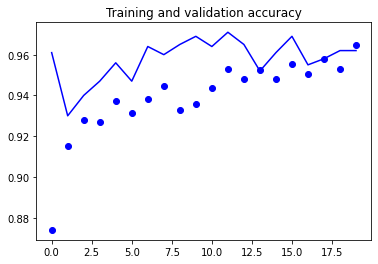

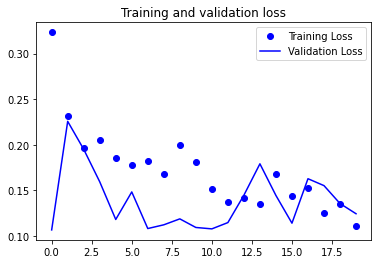

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Test with custom images**

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.utils import load_img, img_to_array  

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving pexels-pixabay-45201.jpg to pexels-pixabay-45201 (2).jpg
1/1 [==============================] - 1s 1s/step
[0.]
pexels-pixabay-45201.jpg is a cat
